This kernel is just for testing some algorithm now. I will add comments later.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")

In [3]:
# train.head()

In [4]:
from collections import Counter

In [5]:
Counter(train['target'])

Counter({0: 179902, 1: 20098})

Split data into testset and train set

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['target', "ID_code"], axis=1), train["target"],
    test_size = 0.33, random_state = 95)

In [8]:
print("train: {} {}, test: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

train: (134000, 200) (134000,), test: (66000, 200) (66000,)


Using Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
RFmodel_baseline = RandomForestRegressor(n_estimators=50, random_state=1937, n_jobs=-1, max_features='sqrt')

In [11]:
from time import time

In [12]:
starttime = time()
RFmodel_baseline.fit(X_train, y_train)
print(time() - starttime)

93.17518591880798


In [13]:
baseline_prediction = RFmodel_baseline.predict(X_test)

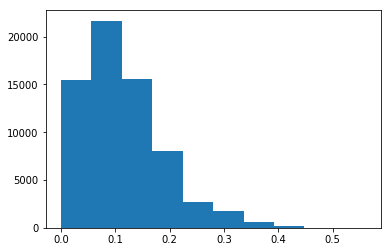

In [14]:
plt.hist(baseline_prediction)
plt.show()

In [15]:
from sklearn.metrics import roc_curve, auc

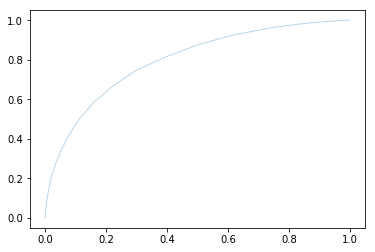

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, baseline_prediction)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=0.3)

plt.show()

In [17]:
roc_auc

0.79740503520048978

Since the data is imbalanced for different targets, we set sample weights

In [18]:
# weighted sample
(a, b) = (9, 1) # 0 vs 1
sample_weight = [a if x == 0 else b for x in y_train]

In [19]:
sample_weight[:20]

[9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 1, 9, 9, 9, 9, 9, 9, 9, 9]

In [20]:
weighted_model = RandomForestRegressor(n_estimators=50, random_state=1937, n_jobs=-1, max_features='sqrt')
starttime = time()
weighted_model.fit(X_train, y_train, sample_weight)
print(time() - starttime)

168.17841172218323


In [21]:
weighted_prediction = weighted_model.predict(X_test)

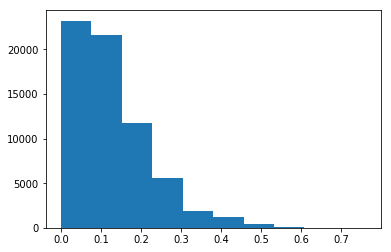

In [22]:
plt.hist(weighted_prediction)
plt.show()

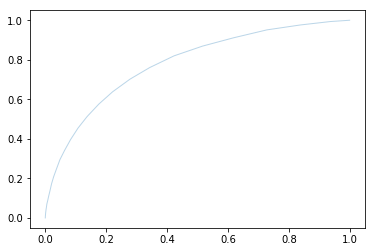

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, weighted_prediction)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=0.3)

plt.show()

In [24]:
roc_auc

0.78085928731762067

Checking variable importance of our forest

In [25]:
importance_pd = pd.DataFrame(weighted_model.feature_importances_,
             index = X_train.columns,
             columns=['importance']).sort_values('importance',  
             ascending=False)
importance_pd.head()

,importance
var_81,0.006773
var_80,0.006691
var_78,0.006650
var_154,0.006520
var_22,0.006454


In [103]:
importance_pd.tail()

,importance
var_74,0.004029
var_192,0.003985
var_120,0.003884
var_140,0.003861
var_103,0.003848


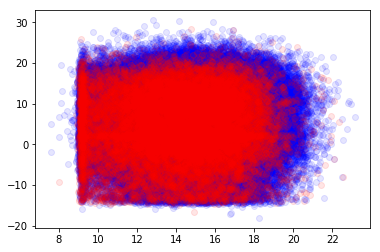

In [26]:
plt.scatter(x=train['var_81'].loc[train['target']==0], y=train['var_80'].loc[train['target']==0], color='blue', alpha=0.1)
plt.scatter(x=train['var_81'].loc[train['target']==1], y=train['var_80'].loc[train['target']==1], color='red', alpha=0.1)
plt.show()

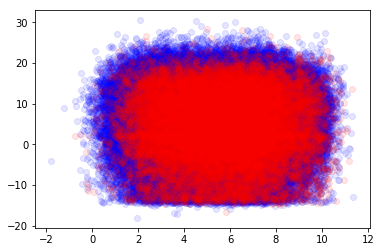

In [27]:
plt.scatter(x=train['var_78'].loc[train['target']==0], y=train['var_80'].loc[train['target']==0], color='blue', alpha=0.1)
plt.scatter(x=train['var_78'].loc[train['target']==1], y=train['var_80'].loc[train['target']==1], color='red', alpha=0.1)
plt.show()

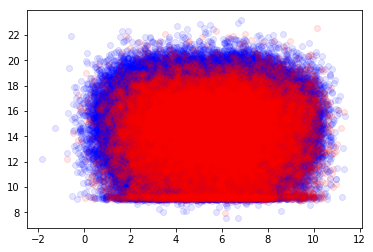

In [28]:
plt.scatter(x=train['var_78'].loc[train['target']==0], y=train['var_81'].loc[train['target']==0], color='blue', alpha=0.1)
plt.scatter(x=train['var_78'].loc[train['target']==1], y=train['var_81'].loc[train['target']==1], color='red', alpha=0.1)
plt.show()

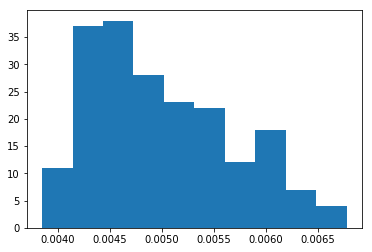

In [29]:
plt.hist(importance_pd['importance'])
plt.show()

SVM

In [30]:
from sklearn import svm

normalizing data, for faster svm calculation

In [31]:
from sklearn.preprocessing import normalize

train_new = normalize(train.drop(["ID_code", "target"], axis=1), norm='l2', axis=0, copy=True, return_norm=False)

train_new = pd.DataFrame(train_new)

train_new.columns = train.drop(["ID_code", "target"], axis=1).columns

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    train_new, train["target"],
    test_size = 0.33, random_state = 95)


linear SVM

In [86]:
linear_svm_model = svm.LinearSVR(
    C=0.01, 
    max_iter=500, 
    intercept_scaling=0.5, 
    random_state=1000, 
    tol=0.1
)
starttime = time()
linear_svm_model.fit(X_train_new, y_train_new)
print(time() - starttime)

0.8913981914520264


In [87]:
linear_svm_prediction = linear_svm_model.predict(X_test_new)

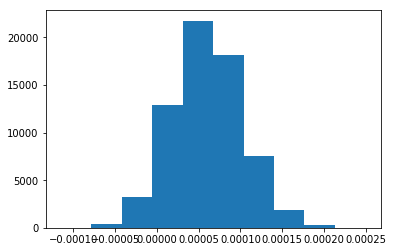

In [88]:
plt.hist(linear_svm_prediction)
plt.show()

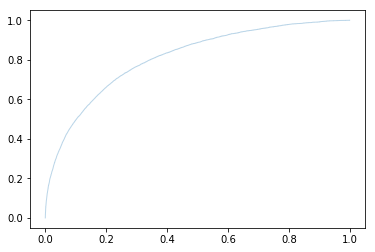

In [89]:
fpr, tpr, thresholds = roc_curve(y_test_new, linear_svm_prediction)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=0.3)

plt.show()

In [90]:
roc_auc

0.81003442505866752

Non-linear SVM

In [187]:
svm_model = svm.SVR(kernel='sigmoid',C=0.05, max_iter=10000, tol=0.5, coef0=1.5)
starttime = time()
svm_model.fit(X_train_new, y_train_new)
print(time() - starttime)

677.9718472957611


/Users/yunzheli/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [188]:
svm_prediction = svm_model.predict(X_test_new)

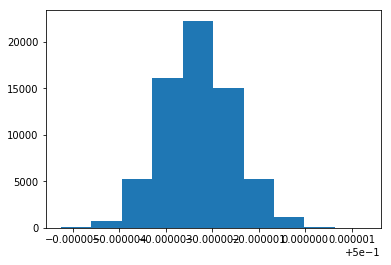

In [189]:
plt.hist(svm_prediction)
plt.show()

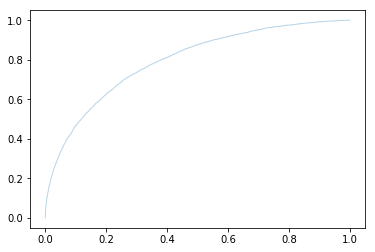

In [190]:
fpr, tpr, thresholds = roc_curve(y_test_new, svm_prediction)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=0.3)

plt.show()

In [191]:
roc_auc

0.79488906489133759

Imbalanced Sampling
Boostrap the smaller target

In [38]:
from sklearn.utils import resample

In [39]:
trainSet = pd.concat([X_train, y_train], axis=1)

In [40]:
target1 = trainSet.loc[train['target'] == 1,]
target0 = trainSet.loc[train['target'] == 0,]

In [41]:
print('1: {}, 0: {}'.format(target1.shape, target0.shape))

1: (13498, 201), 0: (120502, 201)


In [42]:
target1new = target1.sample(target1.shape[0], replace = True)

In [43]:
print(target1new.shape)

(13498, 201)


In [44]:
trainNew = pd.concat([target1new, target0])

In [45]:
resample_model = RandomForestRegressor(n_estimators=50, random_state=1937, n_jobs=-1, max_features='sqrt')
starttime = time()
resample_model.fit(trainNew.drop('target', axis=1), trainNew['target'])
print(time() - starttime)

94.34548568725586


In [46]:
resample_prediction = resample_model.predict(X_test)

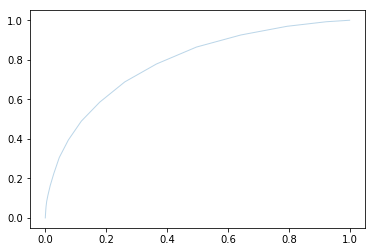

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, resample_prediction)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=0.3)

plt.show()

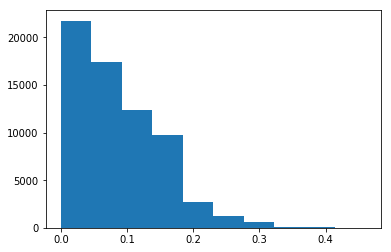

In [48]:
plt.hist(resample_prediction)
plt.show()

In [49]:
roc_auc

0.78463028007346181

Choose the final Model and submit 

In [94]:
starttime = time()
final_model = RandomForestRegressor(
    n_estimators=150, random_state=1937, n_jobs=-1, max_features='sqrt')
# final_model.fit(train.drop(['target','ID_code'] ,axis=1),  train['target'])

# resample
final_model.fit(trainNew.drop(['target','ID_code'] ,axis=1),  trainNew['target'])
print('time: ', time() - starttime)

time:  431.2344026565552


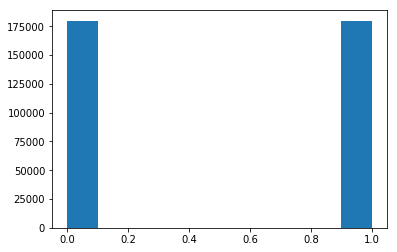

In [106]:
plt.hist(trainNew['target'])
plt.show()

In [2]:
testset = pd.read_csv("./test.csv")
test = testset.drop('ID_code', axis=1)

In [96]:
target = final_model.predict(test)
ID_code = testset['ID_code']
target = pd.DataFrame({"target": target})

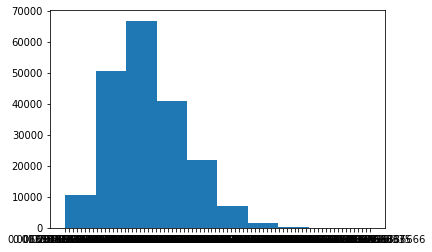

In [126]:
plt.hist(target, bins=10)
plt.show()

In [97]:
submission = pd.concat([ID_code, target], axis =1)

In [98]:
submission.to_csv('submissions.csv', index=False)

In [99]:
import pickle
filename = 'first_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

This dataset has really weired structure, I used some random guess to test if I can get a good result

In [ ]:
from numpy.random import uniform

testset.shape

my_guess = uniform(low=0.0,high=1.0,size=testset.shape[0])

my_guess[my_guess>0.8] = int(1)
my_guess[my_guess<=0.8] = int(0)
target = pd.DataFrame({"target":my_guess})

guess = pd.concat([testset['ID_code'], target], axis =1)

guess.target = guess.target.astype(int)

guess.head()

guess.to_csv('guess.csv', index=False)